# 1.Imports

In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import numpy as np

# 2.Data 

## 2.1 Loaders

### 2.1.1 MNIST Data

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)),
    ])
batch_size = 64

datasets_save_dir = 'Data/'

train_data = datasets.MNIST(root=datasets_save_dir,download=True,train=True, 
    transform=transform)
test_data = datasets.MNIST(root=datasets_save_dir,download=True,train=False, 
    transform=transform)

train_dataloader = DataLoader(train_data,batch_size=batch_size,
    shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=batch_size,shuffle=True)

### 2.1.2 Subsets

In [3]:

subset_sizes = [1000*i for i in range(1,6)] 

subset_loaders = []
for subset_size in subset_sizes:
    subset, _ = random_split(train_data, [subset_size, len(train_data) - subset_size])
    subset_loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
    subset_loaders.append(subset_loader)


## 2.2 Data shape

In [4]:
for images,labels in train_dataloader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


## 3.Model

In [28]:
class Fcnn(nn.Module):
    def __init__(self):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Linear(28*28,256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Linear(64,10),
            nn.Softmax()
        )

    def forward(self,x):
        x = self.block_1(x)
        return x
    

    def initialize_weights_large(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, a=1000, b=2000) 
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
                    


# 4.Training

In [15]:
def train(epochs:int,model,optimizer,criterion,data):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        batch_loss = []
        for batch, (images,labels) in enumerate(data):
            images = images.view(images.shape[0],-1)

            optimizer.zero_grad()
            
            output = model(images)

            loss = criterion(output,labels) 
            loss.backward()

            optimizer.step()
            
            batch_loss.append(loss.item())
            if (batch+1) % 100 == 0:
                print(f'epoch: {epoch+1}, step: {batch+1}/{len(data)} , loss: {loss.item():.4f}')
        avg_batch_loss = sum(batch_loss)/len(batch_loss)
        loss_history.append(avg_batch_loss)
            
    print('Finished training!')
    return loss_history

In [53]:
model = Fcnn()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

train(3,model,optimizer,criterion,train_dataloader)

epoch: 1, step: 100/3750 , loss: 1.8908
epoch: 1, step: 200/3750 , loss: 1.7894
epoch: 1, step: 300/3750 , loss: 1.5904
epoch: 1, step: 400/3750 , loss: 1.7767
epoch: 1, step: 500/3750 , loss: 1.6523
epoch: 1, step: 600/3750 , loss: 1.6694
epoch: 1, step: 700/3750 , loss: 1.6568
epoch: 1, step: 800/3750 , loss: 1.7092
epoch: 1, step: 900/3750 , loss: 1.5276
epoch: 1, step: 1000/3750 , loss: 1.6782
epoch: 1, step: 1100/3750 , loss: 1.5820
epoch: 1, step: 1200/3750 , loss: 1.5494
epoch: 1, step: 1300/3750 , loss: 1.4786
epoch: 1, step: 1400/3750 , loss: 1.5354
epoch: 1, step: 1500/3750 , loss: 1.5785
epoch: 1, step: 1600/3750 , loss: 1.5732
epoch: 1, step: 1700/3750 , loss: 1.6300
epoch: 1, step: 1800/3750 , loss: 1.5348
epoch: 1, step: 1900/3750 , loss: 1.6057
epoch: 1, step: 2000/3750 , loss: 1.5254
epoch: 1, step: 2100/3750 , loss: 1.5164
epoch: 1, step: 2200/3750 , loss: 1.5454
epoch: 1, step: 2300/3750 , loss: 1.5258
epoch: 1, step: 2400/3750 , loss: 1.5317
epoch: 1, step: 2500/3750

## 5.Testing

In [7]:
def test(model, data):
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch, (images,labels) in enumerate(data):
            images = images.view(images.shape[0],-1)

            output = model(images)

            pred = output.data.max(1,keepdim=True)[1]
            
            labels = labels.data.view_as(pred)
            correct += pred.eq(labels).sum()
    accuracy = correct/len(data.dataset)
    print(f'Accuracy: {accuracy:.3f}')
    return accuracy


In [14]:

test(model)
        

Accuracy: 0.970


## 6. Early stopping

In [8]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
def train_es(epochs:int,model,optimizer,criterion,dataloader):
    early_stopper = EarlyStopper(patience=2, min_delta=10)
    model.train()
    for epoch in range(epochs):
        batch_loss_history = []
        for batch, (images,labels) in enumerate(dataloader):
            images = images.view(images.shape[0],-1)

            optimizer.zero_grad()
            
            output = model(images)

            loss = criterion(output,labels)
            loss.backward()

            optimizer.step()
            if (batch+1) % 100 == 0:
                print(f'epoch: {epoch+1}, step: {batch+1}/{len(dataloader)} , loss: {loss.item():.4f}')
            batch_loss_history.append(loss.item().numpy())
        
        print(torch.float)
        epoch_avg_loss = np.average(batch_loss_history)
        if early_stopper.early_stop(epoch_avg_loss):
            print('Early stopping!')
            break
        
        print(f'Epoch: {epoch+1}, avg_loss = {epoch_avg_loss}')
    print('Finished training!')



In [25]:
model = Fcnn()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

train_es(20,model,optimizer,criterion,dataloader = subset_loaders[0])

/home/luki/Dokumenty/Projekty/sieci_projekt2/venv/lib64/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


AttributeError: 'float' object has no attribute 'numpy'

## 7. Training on different subsets

In [9]:
criterion = nn.CrossEntropyLoss()

subset_loss_history = []
subset_accuracy_train = []
subset_accuracy_test = []
for subset in subset_loaders:
    model = Fcnn()
    optimizer = torch.optim.Adam(model.parameters())
    loss_history = train(3,model,optimizer,criterion,subset)
    subset_loss_history.append(loss_history)

    accuracy_test = test(model,test_dataloader)
    accuracy_train = test(model,train_dataloader)
    
    subset_accuracy_train.append(accuracy_train)
    subset_accuracy_test.append(accuracy_test)

/home/luki/Dokumenty/Projekty/sieci_projekt2/venv/lib64/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Finished training!
Accuracy: 0.617
Accuracy: 0.618
Finished training!
Accuracy: 0.829
Accuracy: 0.823
Finished training!
Accuracy: 0.791
Accuracy: 0.787
Finished training!
Accuracy: 0.820
Accuracy: 0.813
Finished training!
Accuracy: 0.777
Accuracy: 0.776


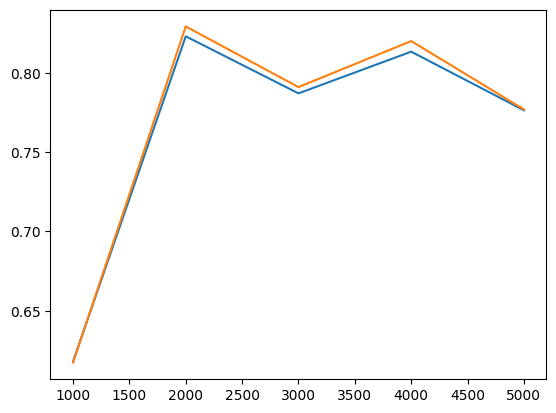

In [10]:
plt.plot(subset_sizes,subset_accuracy_train, label='Train accuracy')
plt.plot(subset_sizes,subset_accuracy_test ,label='Test accuracy')


### 8. Weight initialization

#### 8.1 Weights too high

In [22]:
epochs = 8

model = Fcnn()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

model.initialize_weights_large()
loss_history_2 = train(epochs,model,optimizer,criterion,train_dataloader)


epoch: 1, step: 100/938 , loss: 2.3028
epoch: 1, step: 200/938 , loss: 2.3027
epoch: 1, step: 300/938 , loss: 2.3026
epoch: 1, step: 400/938 , loss: 2.3025
epoch: 1, step: 500/938 , loss: 2.3019
epoch: 1, step: 600/938 , loss: 2.3023
epoch: 1, step: 700/938 , loss: 2.3035
epoch: 1, step: 800/938 , loss: 2.3021
epoch: 1, step: 900/938 , loss: 2.3058
epoch: 2, step: 100/938 , loss: 2.3018
epoch: 2, step: 200/938 , loss: 2.3061
epoch: 2, step: 300/938 , loss: 2.3032
epoch: 2, step: 400/938 , loss: 2.3039
epoch: 2, step: 500/938 , loss: 2.3028
epoch: 2, step: 600/938 , loss: 2.2971
epoch: 2, step: 700/938 , loss: 2.2996
epoch: 2, step: 800/938 , loss: 2.3011
epoch: 2, step: 900/938 , loss: 2.3033
epoch: 3, step: 100/938 , loss: 2.3101
epoch: 3, step: 200/938 , loss: 2.3033
epoch: 3, step: 300/938 , loss: 2.3018
epoch: 3, step: 400/938 , loss: 2.3058
epoch: 3, step: 500/938 , loss: 2.3052
epoch: 3, step: 600/938 , loss: 2.3014
epoch: 3, step: 700/938 , loss: 2.3019
epoch: 3, step: 800/938 ,

In [23]:
test(model,test_dataloader)

Accuracy: 0.113


tensor(0.1135)

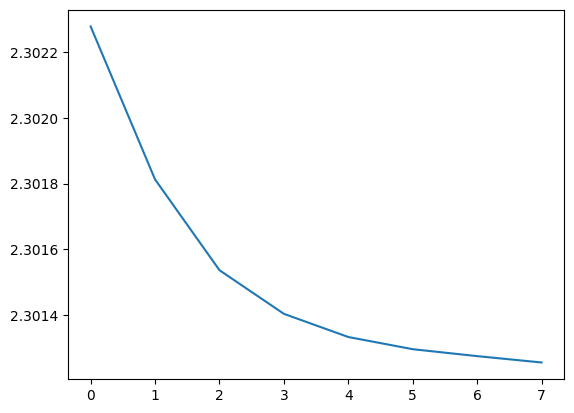

In [24]:
plt.plot(loss_history_2)

#### 8.2 No weight initialization (weights near 0)

In [25]:
model = Fcnn()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

loss_history_3 = train(epochs,model,optimizer,criterion,train_dataloader)

epoch: 1, step: 100/938 , loss: 1.7300
epoch: 1, step: 200/938 , loss: 1.6858
epoch: 1, step: 300/938 , loss: 1.6196
epoch: 1, step: 400/938 , loss: 1.5981
epoch: 1, step: 500/938 , loss: 1.6384
epoch: 1, step: 600/938 , loss: 1.5947
epoch: 1, step: 700/938 , loss: 1.6594
epoch: 1, step: 800/938 , loss: 1.5637
epoch: 1, step: 900/938 , loss: 1.6832
epoch: 2, step: 100/938 , loss: 1.5424
epoch: 2, step: 200/938 , loss: 1.5761
epoch: 2, step: 300/938 , loss: 1.6323
epoch: 2, step: 400/938 , loss: 1.7146
epoch: 2, step: 500/938 , loss: 1.6354
epoch: 2, step: 600/938 , loss: 1.6202
epoch: 2, step: 700/938 , loss: 1.6406
epoch: 2, step: 800/938 , loss: 1.6384
epoch: 2, step: 900/938 , loss: 1.6920
epoch: 3, step: 100/938 , loss: 1.6016
epoch: 3, step: 200/938 , loss: 1.5923
epoch: 3, step: 300/938 , loss: 1.5614
epoch: 3, step: 400/938 , loss: 1.6115
epoch: 3, step: 500/938 , loss: 1.5485
epoch: 3, step: 600/938 , loss: 1.5470
epoch: 3, step: 700/938 , loss: 1.5748
epoch: 3, step: 800/938 ,

In [26]:
test(model,test_dataloader)

Accuracy: 0.951


tensor(0.9509)

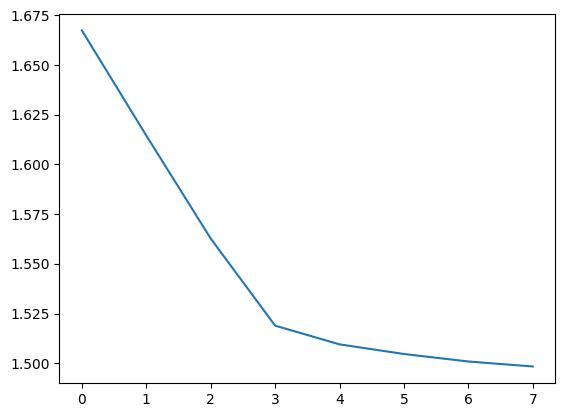

In [27]:
plt.plot(loss_history_3)

Wniosek: sieć jest bardzo czuła na inicjalizację wag